In [81]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
import pandas as pd


resol = 300
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Numerical scheme </h1>

In [82]:
def update_state(psi, qubit_A, mirror, k_tab_individual, k_tab, L, t, dt):

    n_modes = len(k_tab_individual)

    #recovering qubit's and mirror parameters
    omega_A = qubit_A['omega']
    gamma_A = qubit_A['gamma']
    x_A = qubit_A['x']

    omega_M = mirror['omega']
    gamma_M = mirror['gamma']

    #10 one-excitation state
    psi_10 = psi[:2*n_modes + 2]
    q_10g = psi_10[:2*n_modes]
    q_20g = psi_10[-2]
    q_10e = psi_10[-1]

    #prepare the matrix multiplications
    delta_A_matrix = np.concatenate((np.ones(n_modes),np.zeros(n_modes)))

    coupling_matrix_A = delta_A_matrix * 1j*np.sqrt(gamma_A/L) * np.exp(-1j*(k_tab-omega_A)*t + 1j*k_tab*x_A)
    coupling_matrix_M = 1j*np.sqrt(gamma_M/(2*L)) * np.exp(-1j*(k_tab-omega_M)*t)

    #propagate the one-excitation state
    q_10g_new = np.conjugate(coupling_matrix_M) * q_10e + np.conjugate(coupling_matrix_A) * q_20g
    q_20g_new = coupling_matrix_A @ q_10g
    q_10e_new = coupling_matrix_M @ q_10g
    psi_10_new = np.concatenate((q_10g_new, np.array([q_20g_new]),np.array([q_10e_new])))

    
    return -1j*dt*psi_10_new
    

In [83]:
def RG_scheme(psi_init, qubit_A, mirror, k_tab_individual, k_tab, L, T, dt, progress_bar=True):

    nb_pts_time = int(T / dt)
    n_modes = len(k_tab_individual)
    dimension = 2*n_modes + 2

    print("Subspace dimensionality: ", dimension)
    psi_list = np.zeros((nb_pts_time, dimension), dtype=complex)
    # Set the initial conditions
    psi_list[0] = psi_init

        

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        
        psi_current = psi_list[i-1]

        psi_new_1 = update_state(psi_current, qubit_A, mirror, k_tab_individual, k_tab, L, t, dt)
        psi_new_2 = update_state(psi_current + psi_new_1/2, qubit_A, mirror, k_tab_individual, k_tab, L, t + dt/2, dt)
        psi_new_3 = update_state(psi_current + psi_new_2/2, qubit_A, mirror, k_tab_individual, k_tab, L, t + dt/2, dt)
        psi_new_4 = update_state(psi_current + psi_new_3, qubit_A, mirror, k_tab_individual, k_tab, L, t, dt)
        
        psi_new = psi_current + (psi_new_1 + 2*psi_new_2 + 2*psi_new_3 + psi_new_4) / 6

        psi_list[i] = psi_new

    return psi_list
    

<h1> Simulator </h1>

In [84]:
def bk_simulator(qubit_A, mirror, omega_min, omega_max, L, T, dt, print_nb_modes = False, progress_bar=True):

    #quantization of the modes
    k_tab_individual = np.array([2*pi*n/L for n in range(1000000) if (2*pi*n/L >= omega_min and 2*pi*n/L <= omega_max)])
    k_tab = np.concatenate((k_tab_individual, k_tab_individual))
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #initialize the system

    #10 one-excitation state
    q_10g_init = np.zeros(2*n_modes)
    q_20g_init = 1
    q_10e_init = 0
    psi_10_init = np.concatenate((q_10g_init, np.array([q_20g_init]),np.array([q_10e_init])))

    #run the evolution
    print("Evolving the state ...")
    psi_list = RG_scheme(psi_10_init, qubit_A, mirror, k_tab_individual, k_tab, L, T, dt, progress_bar=progress_bar)

    return k_tab_individual, k_tab, psi_list
    

<h1> First test </h1>

In [170]:
L = 100*pi
T = L/2
dt = 0.01

#frequency cutoff
omega_min = 0
omega_max = 20


#mirror
omega_M = 10
gamma_M = 5
mirror = {'omega': omega_M, 'gamma': gamma_M}

#renormalized mirror frequency and mirror decay rate
prefactor_M = 1/(1+gamma_M/(2*pi)*(1/(omega_min - omega_M) - 1/(omega_max - omega_M)))
omega_M_phys = omega_M - gamma_M / (2*pi) * np.log((omega_max-omega_M)/(omega_M - omega_min)) * prefactor_M
gamma_M_phys = gamma_M * prefactor_M


#qubit A

#test : I'll try to ensure that the PHYSICAL frequency of the qubit matches the 50:50 reflection condition

def find_bare_freq(omega_target, bare_gamma, omega_min, omega_max, resol):
    searching_space = np.linspace(1.001*omega_min, 0.999*omega_max, int((omega_max - omega_min)/resol))
    diff = omega_target - (searching_space - bare_gamma/(2*pi) * np.log((omega_max - searching_space) / (searching_space - omega_min)))
    index_min = np.argmin(np.abs(diff))

    return searching_space[index_min]


omega_A_target = omega_M_phys - gamma_M_phys/2
gamma_A = 0.1
#omega_A = find_bare_freq(omega_A_target, gamma_A, omega_min, omega_max, 0.001)
omega_A = omega_A_target - 0.02

x_A = -L/4
qubit_A = {'omega': omega_A, 'gamma': gamma_A, 'x': x_A}

In [171]:
k_tab_individual, k_tab, psi_list = bk_simulator(qubit_A, mirror, omega_min, omega_max, L, T, dt, print_nb_modes = True, progress_bar=True)

Number of modes:  1001
Evolving the state ...
Subspace dimensionality:  2004


  0%|          | 0/15706 [00:00<?, ?it/s]

Store the coef and observe some probabilities

In [172]:
n_modes = len(k_tab_individual)
nb_pts_time = int(T/dt)
time_list = np.linspace(0,T,nb_pts_time)

q_10g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
q_20g_list = np.zeros((nb_pts_time,), dtype=complex)
q_10e_list = np.zeros((nb_pts_time,), dtype=complex)


for i in tqdm(range(nb_pts_time)):
    psi = psi_list[i]

    #10 one-excitation state
    psi_10 = psi[:2*n_modes + 2]
    q_10g_list[i] = psi_10[:2*n_modes]
    q_20g_list[i] = psi_10[-2]
    q_10e_list[i] = psi_10[-1]

  0%|          | 0/15707 [00:00<?, ?it/s]

<h1> Visualize the wave-packet </h1>

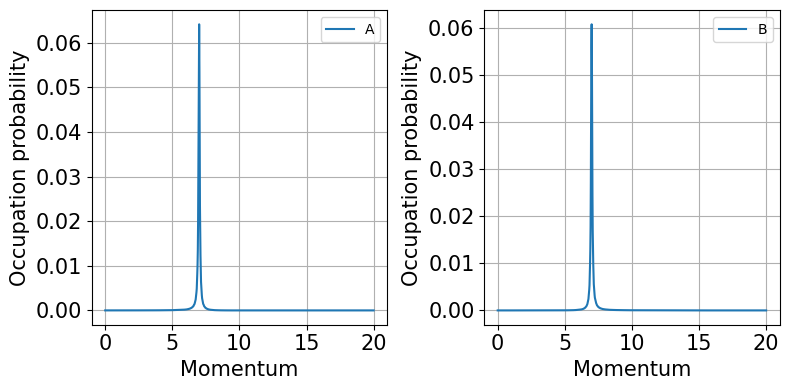

In [173]:
t = L/2
time_index = np.argmin(np.abs(time_list - t))
q_10g_current = q_10g_list[time_index]


fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(k_tab_individual, np.abs(q_10g_current[:n_modes])**2, label="A")
ax[1].plot(k_tab_individual, np.abs(q_10g_current[n_modes:])**2, label="B")

#font size
for i in range(2):
    for item in [ax[i].xaxis.label, ax[i].yaxis.label]:
        item.set_fontsize(15)

    for item in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        item.set_fontsize(15)
    
    ax[i].set_xlabel('Momentum')
    ax[i].set_ylabel('Occupation probability')
    #ax[i].set_ylim(-0.01,0.05)
    ax[i].grid()
    ax[i].set_axisbelow(True)  
    ax[i].legend(prop={'size': 10})

#ax[0].vlines(omega_A, ymin=0, ymax=max(np.abs(q_10g_current[:n_modes])**2),color='red', linestyle='--', label='Qubit A frequency')
#ax[0].set_xlim(0.99*omega_A, 1.01*omega_A)
plt.tight_layout()
plt.show()

<h1> Probabilites PA and PB </h1>

Reflection probability = 0.4995009277379117
Transmission probability = 0.5004980005060898


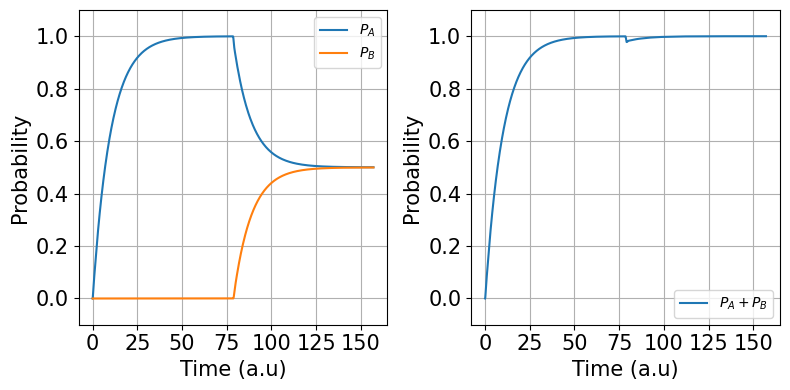

In [174]:
P_A_list = np.sum(np.abs(q_10g_list[:,:n_modes])**2, axis=1)
P_B_list = np.sum(np.abs(q_10g_list[:,n_modes:])**2, axis=1)

print(f"Reflection probability = {P_B_list[-1]}")
print(f"Transmission probability = {P_A_list[-1]}")

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot(time_list, P_A_list, label=r'$P_A$')
ax[0].plot(time_list, P_B_list, label=r'$P_B$')


ax[1].plot(time_list, P_A_list + P_B_list, label=r'$P_A + P_B$')


#font size
for i in range(2):
    for item in [ax[i].xaxis.label, ax[i].yaxis.label]:
        item.set_fontsize(15)

    for item in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        item.set_fontsize(15)
    
    ax[i].set_xlabel('Time (a.u)')
    ax[i].set_ylabel('Probability')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].grid()
    ax[i].set_axisbelow(True)  
    ax[i].legend(prop={'size': 10})

plt.tight_layout()
plt.show()

<h1> Check reflection / transmission against qubit freq </h1>

In [154]:
L = 100*pi
T = L/2
dt = 0.01

#frequency cutoff
omega_min = 0
omega_max = 20


#mirror
omega_M = 10
gamma_M = 5
mirror = {'omega': omega_M, 'gamma': gamma_M}

#renormalized mirror frequency and mirror decay rate
prefactor_M = 1/(1+gamma_M/(2*pi)*(1/(omega_min - omega_M) - 1/(omega_max - omega_M)))
omega_M_phys = omega_M - gamma_M / (2*pi) * np.log((omega_max-omega_M)/(omega_M - omega_min)) * prefactor_M
gamma_M_phys = gamma_M * prefactor_M


nb_pts = 19
omega_A_tab = np.linspace(5,15, nb_pts)
reflection_proba_tab = np.zeros(nb_pts)

for i in tqdm(range(nb_pts)):

    #qubit A
    omega_A = omega_A_tab[i]
    gamma_A = 0.1
    x_A = -L/4
    qubit_A = {'omega': omega_A, 'gamma': gamma_A, 'x': x_A}

    k_tab_individual, k_tab, psi_list = bk_simulator(qubit_A, mirror, omega_min, omega_max, L, T, dt, print_nb_modes = False, progress_bar=False)
    
    n_modes = len(k_tab_individual)
    q_10g_list_final = psi_list[-1,:2*n_modes]
    reflection_proba_tab[i] = np.sum(np.abs(q_10g_list_final[n_modes:])**2)

  0%|          | 0/19 [00:00<?, ?it/s]

Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subspace dimensionality:  2004
Evolving the state ...
Subsp

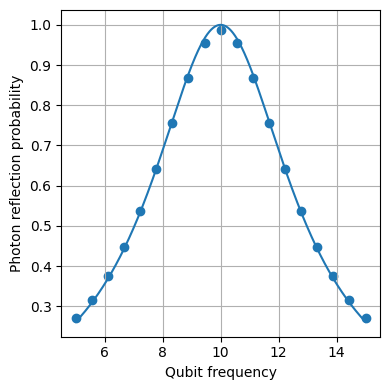

In [159]:
#theory check
omega_A_theory = np.linspace(5,15,1000)
theory = 1 / (1 + (omega_A_theory - omega_M_phys)**2 / (gamma_M_phys/2)**2)

fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(omega_A_theory, theory)
ax.scatter(omega_A_tab, reflection_proba_tab)
ax.set_xlabel("Qubit frequency")
ax.set_ylabel("Photon reflection probability")
ax.grid()

fig.tight_layout()
plt.show()